In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm, skew, kurtosis
import seaborn as sns

!pip install openpyxl



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Load data
covariance_matrix = pd.read_excel('covariance_matrix.xlsx', index_col=0)
init_values = pd.read_excel('init_values.xlsx', index_col=0)

# Parameters
mu = np.array([0, 0.07 / 52, 0.06 / 52] + [0] * (len(covariance_matrix) - 3))
sigma = covariance_matrix.values
initial_values = init_values.values.flatten()
np.random.seed(55) #Den samme simulering

# Simulation settings
n_steps = 52 # Number of time steps (weekly for 1 year)
n_simulations = 10000 # Number of simulated paths
delta_t = 1 / 52 # Time step size
horizon = 1

# Question 1

Text(0, 0.5, 'Density')

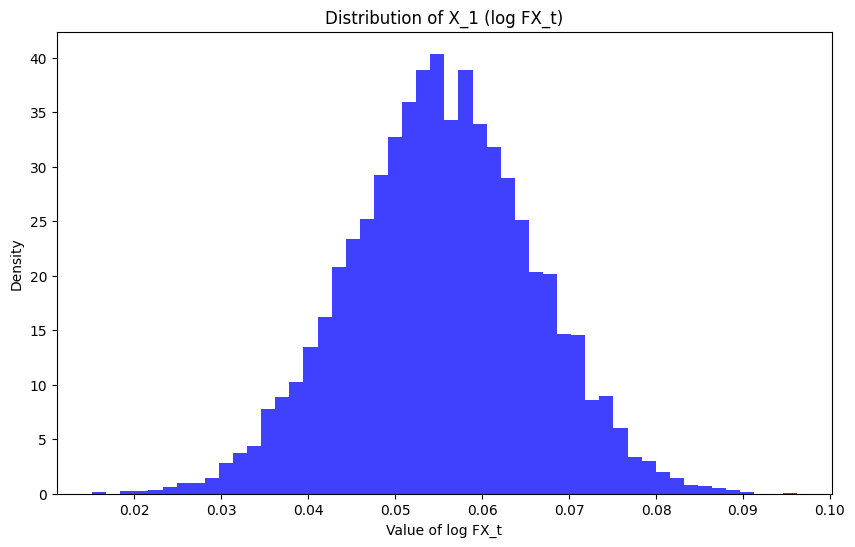

In [3]:
# Initialize matrix to store simulated paths
X_t = np.zeros((n_simulations, len(initial_values), n_steps + 1))
X_t[:, :, 0] = initial_values  # Set initial values at time t=0

# Simulate paths
for t in range(1, n_steps + 1):
    # Simulate weekly increments from N(mu, sigma)
    delta_X_t = np.random.multivariate_normal(mu, sigma, size=n_simulations)
    X_t[:, :, t] = X_t[:, :, t - 1] + delta_X_t

# Extract X_1 (distribution of first step)
X_1 = X_t[:, :, 1]

# Plot distribution for the first variable in X_1 (log FX_t)
plt.figure(figsize=(10, 6))
plt.hist(X_1[:, 0], bins=50, density=True, alpha=0.75, color='blue')
plt.title("Distribution of X_1 (log FX_t)")
plt.xlabel("Value of log FX_t")
plt.ylabel("Density")

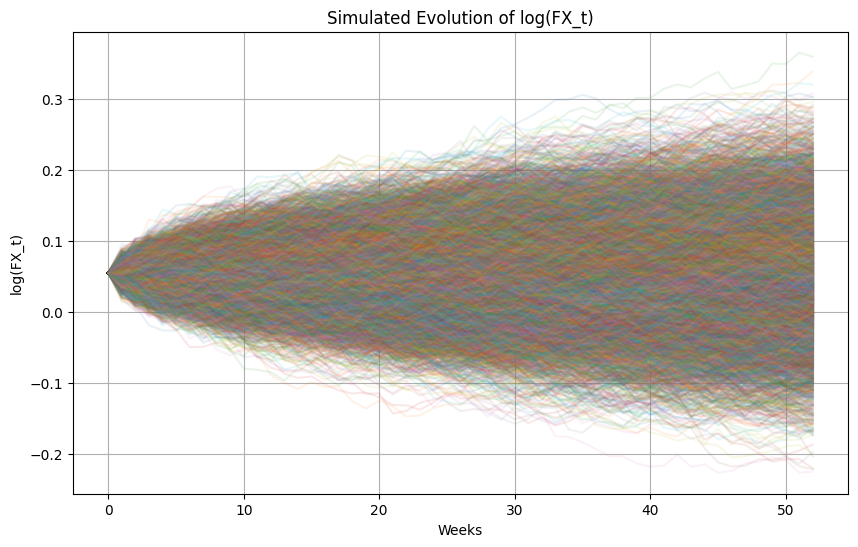

In [4]:
# Extract log(FX_t) (assuming it's the first element in X_t)
log_FX_t = X_t[:, 0, :]

# Visualization of log(FX_t)
plt.figure(figsize=(10, 6))
for i in range(n_simulations):  # Plot 10000 random paths
    plt.plot(range(n_steps + 1), log_FX_t[i, :], alpha=0.1)
plt.title("Simulated Evolution of log(FX_t)")
plt.xlabel("Weeks")
plt.ylabel("log(FX_t)")
plt.grid()
plt.show()


# Question 2

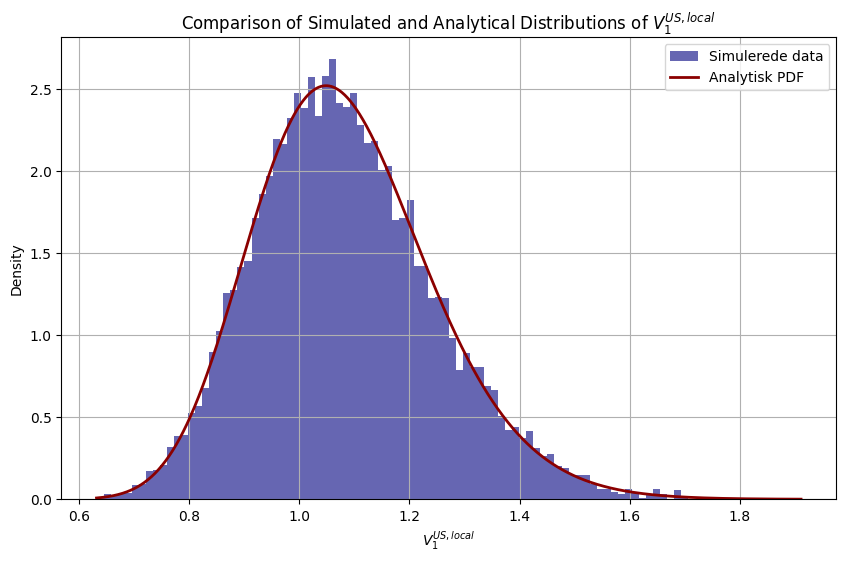

In [5]:
# --- Parametre ---
V0_US_local = np.exp(init_values.loc['EQV US', 'initial values']) 
V0_EUR_local = np.exp(init_values.loc['EQV EUR', 'initial values']) 

# Årlig drift og volatilitet til analytisk lognormal fordeling
mu_log_annual = mu[1] * 52  # Årlig drift (akkumuleret fra ugentlig drift)
sigma_log_annual = np.sqrt(sigma[1, 1] * 52)  # Årlig volatilitet (skaleret fra ugentlig)

# Analytisk log-normal fordeling
scale = V0_US_local * np.exp(mu_log_annual)  # Scale-parameter for log-normal
s = sigma_log_annual  # Årlig standardafvigelse i log-skala

# --- Simulering af V_1^{US,local} med årlig drift og volatilitet ---
n_simulations = 10000
log_V_US_local_1_simulated = np.random.normal(loc=mu_log_annual, scale=sigma_log_annual, size=n_simulations)
V_US_local_1_simulated = V0_US_local * np.exp(log_V_US_local_1_simulated)  # Tilbage i niveau-skala

# Sammenligning mellem simulation og analytisk fordeling
x_values = np.linspace(min(V_US_local_1_simulated), max(V_US_local_1_simulated), 1000)  # Værdier til analytisk PDF
pdf_values = lognorm.pdf(x_values, s=s, scale=scale)

# --- Visualisering ---
plt.figure(figsize=(10, 6))

# Histogram for simulerede data
plt.hist(V_US_local_1_simulated, bins=100, density=True, color='navy', alpha=0.6, label='Simulerede data')

# Analytisk PDF
plt.plot(x_values, pdf_values, color='darkred', linewidth=2, label='Analytisk PDF')

# Titel og labels
plt.title("Comparison of Simulated and Analytical Distributions of $V_1^{US,local}$")
plt.xlabel("$V_1^{US,local}$")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


# Question 3

Zero Coupon Obligation for 5 Year EUR: 0.9046234128748379
Zero Coupon Obligation for 5 Year USD: 0.8294081241634763


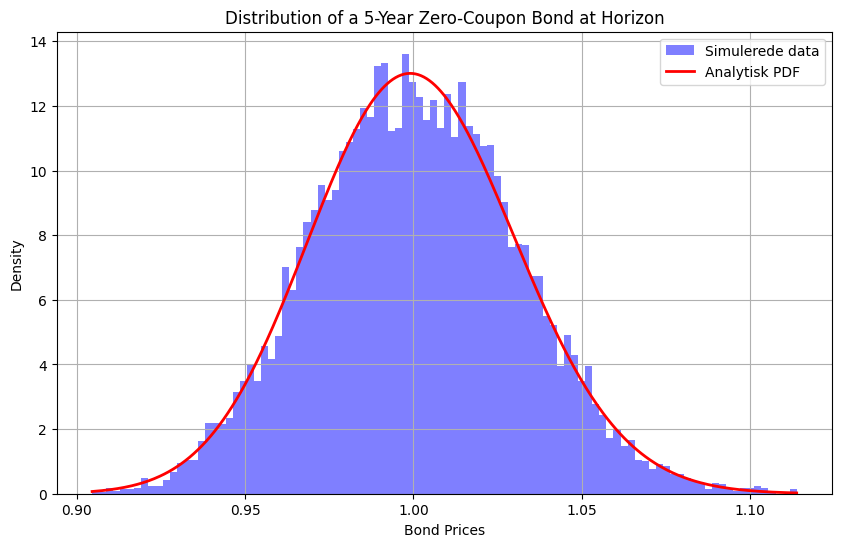

Simulated Mean: 1.0009, Analytical Mean: 1.0005
Simulated Std: 0.0307, Analytical Std: 0.0307


In [7]:
from scipy.stats import lognorm
import numpy as np
import matplotlib.pyplot as plt

# --- Parametre for 5-årig zero-coupon obligation ---
tau = 5  # Løbetid (5 år)
delta_t = 1 / 52  # Ugentlige trin

# Beregn zero-coupon bond priser med løbetid på 5 år
y_USD_5Y_0 = init_values.loc['5Y USD', 'initial values']   # Årlig rente for USD
y_EUR_5Y_0 = init_values.loc['5Y EUR', 'initial values']   # Årlig rente for EUR


Z_USD_5Y_local = np.exp(-y_USD_5Y_0 * tau)  # 5-årig USD zero-coupon bond
Z_EUR_5Y = np.exp(-y_EUR_5Y_0 * tau)  # 5-årig EUR zero-coupon bond
print("Zero Coupon Obligation for 5 Year EUR:", Z_EUR_5Y)
print("Zero Coupon Obligation for 5 Year USD:", Z_USD_5Y_local)

# Renter (sørg for, at indeks matcher 5-årige renter)
mu_y = mu[4]  # Antaget drift for 5-årig rente (Tjek, at mu[4] er korrekt)
sigma_y_weekly = np.sqrt(sigma[6, 6])  # Ugentlig volatilitet for 5-årig rente
sigma_y_annual = np.sqrt(sigma[6, 6] * 52)  # Årlig volatilitet for 5-årig rente

# --- Analytisk fordeling af obligationens log-pris ---
mu_log_P = -tau * mu_y  # Drift for log-prisen
sigma_log_P = tau * sigma_y_annual  # Volatilitet for log-prisen

# Lognormal parametre
scale = np.exp(mu_log_P)  # Scale-parameter for log-normal fordeling
s = sigma_log_P  # Standardafvigelse for log-prisen

# --- Simulering af obligationens log-pris ---
n_simulations = 10000
log_P_simulated = np.random.normal(loc=mu_log_P, scale=sigma_log_P, size=n_simulations)
P_simulated = np.exp(log_P_simulated)  # Konverter log-prisen tilbage til niveau

# --- Analytisk PDF ---
x_values = np.linspace(P_simulated.min(), P_simulated.max(), 500)
pdf_values = lognorm.pdf(x_values, s=s, scale=scale)

# --- Visualisering ---
plt.figure(figsize=(10, 6))
plt.hist(P_simulated, bins=100, density=True, color='blue', alpha=0.5, label='Simulerede data')
plt.plot(x_values, pdf_values, color='red', linewidth=2, label='Analytisk PDF')
plt.title("Distribution of a 5-Year Zero-Coupon Bond at Horizon")
plt.xlabel("Bond Prices")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

mean_simulated = np.mean(P_simulated)
std_simulated = np.std(P_simulated)

mean_analytical = lognorm.mean(s=s, scale=scale)
std_analytical = lognorm.std(s=s, scale=scale)

print(f"Simulated Mean: {mean_simulated:.4f}, Analytical Mean: {mean_analytical:.4f}")
print(f"Simulated Std: {std_simulated:.4f}, Analytical Std: {std_analytical:.4f}")



# Question 4

[0.92729639 0.89339812 0.90509313 ... 0.85398621 0.90045186 0.9197913 ]
Mean of P1:
 [1.06134626 1.08537496 1.07518827 0.86010849 0.89244095]

Covariance matrix of P1:
 [[ 6.81381614e-03  4.80982143e-06 -4.38192776e-05 -2.68652290e-05
  -2.76970377e-05]
 [ 4.80982143e-06  2.61954073e-02  2.03843537e-02 -5.70508125e-07
  -1.65229007e-05]
 [-4.38192776e-05  2.03843537e-02  2.83581683e-02  3.67060865e-05
   4.55880630e-06]
 [-2.68652290e-05 -5.70508125e-07  3.67060865e-05  6.71938483e-04
   5.37614906e-04]
 [-2.76970377e-05 -1.65229007e-05  4.55880630e-06  5.37614906e-04
   4.91389481e-04]]


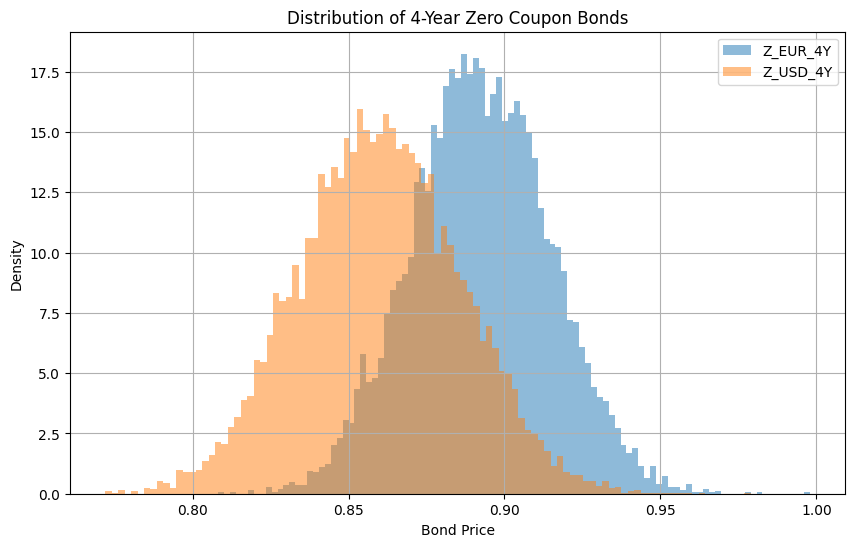

In [8]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(55)  # Ensartet simulering

# Parametre
V_US_local_0 = np.exp(init_values.loc['EQV US', 'initial values']) 
V_EUR_0 = np.exp(init_values.loc['EQV EUR', 'initial values']) 
n_simulations = 10000
n_steps = 52  # 1 år, ugentlige trin


# Simuler ændringer i markedsinvarianter
delta_X_1 = np.random.multivariate_normal(mean=mu, cov=sigma, size=(n_simulations, n_steps))


# Summer ugentlige ændringer i logaritmiske værdier
delta_log_V_US_local = delta_X_1[:, :, 1].sum(axis=1)  # Kolonne for US equities ændringer
delta_log_V_EUR = delta_X_1[:, :, 2].sum(axis=1)       # Kolonne for EUR equities ændringer

# Beregn V_US,1 og V_EUR,1
V_US_local_1 = V_US_local_0 * np.exp(delta_log_V_US_local)
V_EUR_1 = V_EUR_0 * np.exp(delta_log_V_EUR)

# Simuler ugentlige ændringer i log FX
delta_log_FX = np.random.multivariate_normal(mean=mu, cov=sigma, size=(n_simulations, n_steps))[:, :, 0]

# Summer ugentlige ændringer for at få årlig ændring
delta_log_FX_1 = delta_log_FX.sum(axis=1)

# Beregn FX_1 ved at eksponentiere ændringen
FX_0 = np.exp(init_values.loc['fx_spot', 'initial values'])  # Spot FX rate (EUR/USD)
FX_1 = FX_0 * np.exp(delta_log_FX_1)

delta_X_1 = np.random.multivariate_normal(mean=mu, cov=sigma, size=(n_simulations, n_steps))

# Udtræk initial yields
y_3Y_USD_0 = init_values.loc['3Y USD', 'initial values']
y_5Y_USD_0 = init_values.loc['5Y USD', 'initial values']

# Simuler ugentlige ændringer for 3Y og 5Y yields
delta_y_3Y_USD = delta_X_1[:, :, 11]  # Kolonne for 3Y USD yield ændringer
delta_y_5Y_USD = delta_X_1[:, :, 12]  # Kolonne for 5Y USD yield ændringer

# Akkumuler ugentlige ændringer for at få årlige yields
y_3Y_USD_1 = y_3Y_USD_0 + delta_y_3Y_USD.sum(axis=1)
y_5Y_USD_1 = y_5Y_USD_0 + delta_y_5Y_USD.sum(axis=1)

# Interpolation for 4-årig yield
y_4Y_USD_1 = y_3Y_USD_1 + 0.5 * (y_5Y_USD_1 - y_3Y_USD_1)

# Beregn nulkuponobligationspriser
Z_USD_4Y_1_local = np.exp(-y_4Y_USD_1 * 4)  # 4-årig USD bond


# Udtræk initial yields
y_3Y_EUR_0 = init_values.loc['3Y EUR', 'initial values']
y_5Y_EUR_0 = init_values.loc['5Y EUR', 'initial values']

# Simuler ugentlige ændringer for 3Y og 5Y yields
delta_y_3Y_EUR = delta_X_1[:, :, 5]  # Kolonne for 3Y USD yield ændringer
delta_y_5Y_EUR = delta_X_1[:, :, 6]  # Kolonne for 5Y USD yield ændringer

# Akkumuler ugentlige ændringer for at få årlige yields
y_3Y_EUR_1 = y_3Y_EUR_0 + delta_y_3Y_EUR.sum(axis=1)
y_5Y_EUR_1 = y_5Y_EUR_0 + delta_y_5Y_EUR.sum(axis=1)

# Interpolation for 4-årig yield
y_4Y_EUR_1 = y_3Y_EUR_1 + 0.5 * (y_5Y_USD_1 - y_3Y_EUR_1)

# Beregn nulkuponobligationspriser
Z_EUR_4Y_1 = np.exp(-y_4Y_EUR_1 * 4)  # 4-årig USD bond
print(Z_EUR_4Y_1)

# Kombinér til P1
P1 = np.c_[FX_1, V_US_local_1, V_EUR_1, Z_USD_4Y_1_local, Z_EUR_4Y_1]

# Beregn gennemsnit og kovarians
P1_mean = P1.mean(axis=0)
P1_cov = np.cov(P1, rowvar=False)

# Udskriv resultater
print("Mean of P1:\n", P1_mean)
print("\nCovariance matrix of P1:\n", P1_cov)

# Visualisering af 4-årige obligationspriser
plt.figure(figsize=(10, 6))
plt.hist(Z_EUR_4Y_1, bins=100, density=True, alpha=0.5, label='Z_EUR_4Y')
plt.hist(Z_USD_4Y_1_local, bins=100, density=True, alpha=0.5, label='Z_USD_4Y')
plt.title("Distribution of 4-Year Zero Coupon Bonds")
plt.xlabel("Bond Price")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


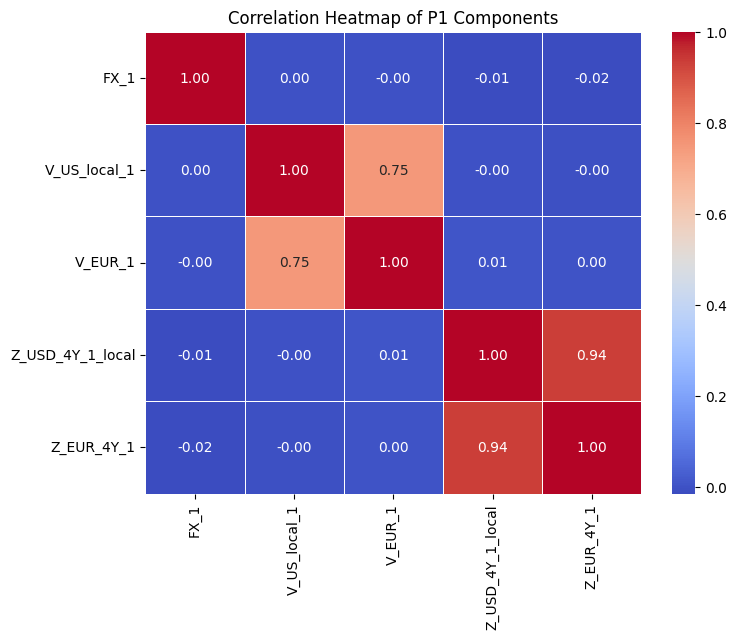

In [9]:
# Convert P1 to DataFrame for easier manipulation
P1_df = pd.DataFrame(P1, columns=["FX_1", "V_US_local_1", "V_EUR_1", "Z_USD_4Y_1_local", "Z_EUR_4Y_1"])

# Calculate the correlation matrix
correlation_matrix = P1_df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of P1 Components")
plt.show()

# Question 5

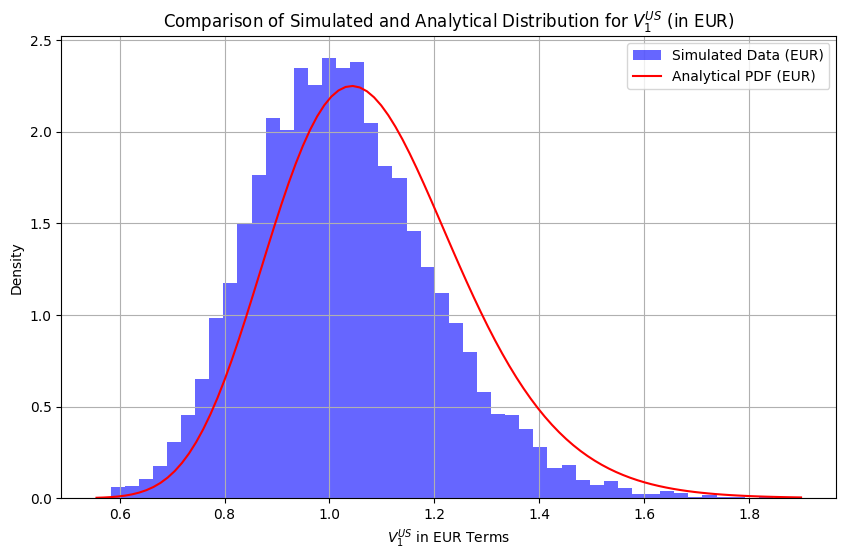

In [10]:
# Convert all components to EUR
FX_1_inv = 1 / FX_1  # Inverse of FX rate for conversion
V_US_1_EUR = V_US_local_1 * FX_1_inv  # US equity in EUR
Z_USD_4Y_1_EUR = Z_USD_4Y_1_local * FX_1_inv  # USD bond price in EUR

# Construct P1^EUR
P1_EUR = np.c_[FX_1_inv, V_US_1_EUR, V_EUR_1, Z_USD_4Y_1_EUR, Z_EUR_4Y_1]

# Analytiske parametre
mu_log_V_US = mu[1] * n_steps  # Log-middelværdi for US equities
sigma_log_V_US = np.sqrt(sigma[1, 1] * n_steps)  # Log-volatilitet for US equities
mu_log_FX_inv = -mu[0] * n_steps  # Log-middelværdi for inverse FX rate
sigma_log_FX_inv = np.sqrt(sigma[0, 0] * n_steps)  # Log-volatilitet for FX rate

# Kombiner parametre for V_US_1_EUR
mu_EUR = mu_log_V_US + mu_log_FX_inv
sigma_EUR = np.sqrt(sigma_log_V_US**2 + sigma_log_FX_inv**2)

# Simuleret data for V_US_1 i EUR
x_values = np.linspace(V_US_1_EUR.min(), V_US_1_EUR.max(), 100)
pdf_values = lognorm.pdf(x_values, s=sigma_EUR, scale=np.exp(mu_EUR))

# Plot sammenligning
plt.figure(figsize=(10, 6))
plt.hist(V_US_1_EUR, bins=50, density=True, alpha=0.6, color="blue", label="Simulated Data (EUR)")
plt.plot(x_values, pdf_values, color="red", label="Analytical PDF (EUR)")
plt.title("Comparison of Simulated and Analytical Distribution for $V_1^{US}$ (in EUR)")
plt.xlabel("$V_1^{US}$ in EUR Terms")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()



# Question 6

In [11]:
# Extract initial FX and yield values
FX_0 = np.exp(init_values.loc['fx_spot', 'initial values'])  # Spot FX rate (EUR/USD)
y_USD_1Y_0 = init_values.loc['1Y USD', 'initial values']  # 1Y USD yield
y_EUR_1Y_0 = init_values.loc['1Y EUR', 'initial values']  # 1Y EUR yield

# Calculate the forward price F_0^1
F01 = FX_0 * np.exp(-(y_USD_1Y_0 - y_EUR_1Y_0)*1 )  # One year horizon
print(f"One-year forward price (F_0^1): {F01}")

One-year forward price (F_0^1): 1.036745084696524


In [12]:
FX_1 = FX_0 * np.exp(delta_log_FX_1)
V_US_0_EUR = V_US_local_0/FX_0
V_US_1_EUR = V_US_local_1*FX_1_inv

# Beregn zero-coupon bond priser med løbetid på 5 år
y_USD_5Y_0 = init_values.loc['5Y USD', 'initial values']   # Årlig rente for USD
y_EUR_5Y_0 = init_values.loc['5Y EUR', 'initial values']   # Årlig rente for EUR

Z_USD_5Y_local = np.exp(-y_USD_5Y_0 * 5)  # 5-årig USD zero-coupon bond
Z_EUR_5Y = np.exp(-y_EUR_5Y_0 * 5)  # 5-årig EUR zero-coupon bond
Z_USD_5Y_0_EUR = Z_USD_5Y_local/FX_0


# PnL_1 calculation in EUR
PnL1_FX = (1 / F01) - (1 / FX_1)  # Adjusted PnL for FX forward
PnL1_US = (V_US_1_EUR - V_US_0_EUR)  # US Equities in EUR
PnL1_EUR = V_EUR_1 - V_EUR_0  # EUR Equities
PnL1_USD_Bond = (Z_USD_4Y_1_EUR - Z_USD_5Y_0_EUR)  # USD Bonds in EUR
PnL1_EUR_Bond = Z_EUR_4Y_1 - Z_EUR_5Y  # EUR Bonds

# Combine into PnL_1 vector
PnL_1_EUR = np.c_[PnL1_FX, PnL1_US, PnL1_EUR, PnL1_USD_Bond, PnL1_EUR_Bond]

# Expected PnL and covariance
E_PnL = np.mean(PnL_1_EUR, axis=0)
Sigma_PnL = np.cov(PnL_1_EUR, rowvar=False)

print(E_PnL)
print(Sigma_PnL)


print(np.mean(E_PnL))
print(np.mean(Sigma_PnL))


[ 0.01668037  0.08259375  0.07518827  0.03050913 -0.01218246]
[[ 5.39439044e-03 -5.85833815e-03 -3.98742402e-05 -4.66426299e-03
  -2.56739737e-05]
 [-5.85833815e-03  3.00955753e-02  1.94014958e-02  5.06378057e-03
   1.17197641e-05]
 [-3.98742402e-05  1.94014958e-02  2.83581683e-02  6.95623984e-05
   4.55880630e-06]
 [-4.66426299e-03  5.06378057e-03  6.95623984e-05  4.64059597e-03
   5.31851193e-04]
 [-2.56739737e-05  1.17197641e-05  4.55880630e-06  5.31851193e-04
   4.91389481e-04]]
0.03855781214350111
0.003918790312741874



PnL_matrix shape: (10000, 5)
PnL_matrix (first 5 rows):
 [[ 0.03528809  0.18335208  0.00454271  0.03550759  0.02267298]
 [ 0.20946099 -0.28683204 -0.29603122 -0.12831132 -0.01122529]
 [-0.00732068  0.04369236  0.02932639  0.08061766  0.00046972]
 [ 0.0535447   0.12358822  0.16356781  0.02249263  0.01225747]
 [-0.02409073  0.16350908  0.04696144  0.07265952 -0.00788585]]
Korrelation Matrix:
[[ 1.         -0.45978196 -0.0032239  -0.93223405 -0.01576918]
 [-0.45978196  1.          0.66411731  0.42848604  0.00304758]
 [-0.0032239   0.66411731  1.          0.00606385  0.00122123]
 [-0.93223405  0.42848604  0.00606385  1.          0.35220079]
 [-0.01576918  0.00304758  0.00122123  0.35220079  1.        ]]


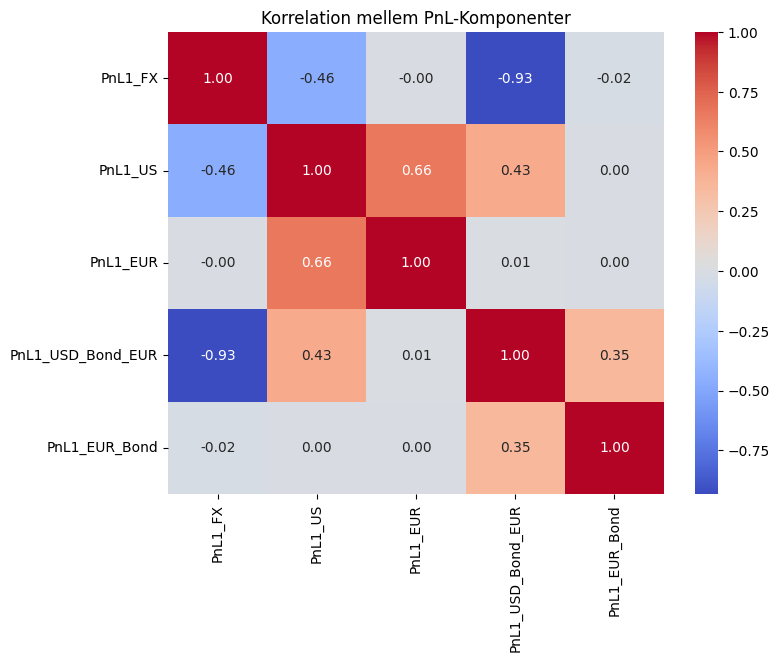

In [13]:
print("\nPnL_matrix shape:", PnL_1_EUR.shape)
print("PnL_matrix (first 5 rows):\n", PnL_1_EUR[:5])

correlation_matrix = np.corrcoef(PnL_1_EUR, rowvar=False)
print("Korrelation Matrix:")
print(correlation_matrix)

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['PnL1_FX', 'PnL1_US', 'PnL1_EUR', 'PnL1_USD_Bond_EUR', 'PnL1_EUR_Bond'],
            yticklabels=['PnL1_FX', 'PnL1_US', 'PnL1_EUR', 'PnL1_USD_Bond_EUR', 'PnL1_EUR_Bond'])
plt.title('Korrelation mellem PnL-Komponenter')
plt.show()

In [14]:
# Vælg en specifik PnL-komponent til visualisering (f.eks. PnL for FX forward)
PnL_FX = PnL_1_EUR[:, 0]  # Første kolonne for FX forward kontrakt

# Beregn analytiske parametre for normalfordelingen
mu_FX = E_PnL[0]  # Forventning for FX forward PnL
sigma_FX = np.sqrt(Sigma_PnL[0, 0])  # Standardafvigelse for FX forward PnL

# Generer analytisk normalfordeling
x_values = np.linspace(PnL_FX.min(), PnL_FX.max(), 100)
pdf_values = norm.pdf(x_values, loc=mu_FX, scale=sigma_FX)


# Vurder fordeling for hele PnL_1_EUR
# Multivariat normal test for hele vektoren
print("Expected PnL (E[PnL]):", E_PnL)
print("Covariance Matrix (Sigma_PnL):\n", Sigma_PnL)

# Beregn samlet portefølje PnL
h = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Eksempel på holdningsvektor
PnL_portfolio = PnL_1_EUR @ h  # Lineær kombination af individuelle PnLs

# Visualisering af portefølje-PnL
mu_portfolio = np.mean(PnL_portfolio)
sigma_portfolio = np.std(PnL_portfolio)

# Analytisk normalfordeling for portefølje
x_portfolio = np.linspace(PnL_portfolio.min(), PnL_portfolio.max(), 100)
pdf_portfolio = norm.pdf(x_portfolio, loc=mu_portfolio, scale=sigma_portfolio)


print(f"Portfolio PnL - Expected Value: {mu_portfolio:.4f}, Standard Deviation: {sigma_portfolio:.4f}")


Expected PnL (E[PnL]): [ 0.01668037  0.08259375  0.07518827  0.03050913 -0.01218246]
Covariance Matrix (Sigma_PnL):
 [[ 5.39439044e-03 -5.85833815e-03 -3.98742402e-05 -4.66426299e-03
  -2.56739737e-05]
 [-5.85833815e-03  3.00955753e-02  1.94014958e-02  5.06378057e-03
   1.17197641e-05]
 [-3.98742402e-05  1.94014958e-02  2.83581683e-02  6.95623984e-05
   4.55880630e-06]
 [-4.66426299e-03  5.06378057e-03  6.95623984e-05  4.64059597e-03
   5.31851193e-04]
 [-2.56739737e-05  1.17197641e-05  4.55880630e-06  5.31851193e-04
   4.91389481e-04]]
Portfolio PnL - Expected Value: 0.0386, Standard Deviation: 0.0626


Kolmogorov-Smirnov Test for Normality:
KS Statistic: 0.0193, P-Value: 0.0012
Testen forkaster hypotesen om normalfordeling (p < 0.05).


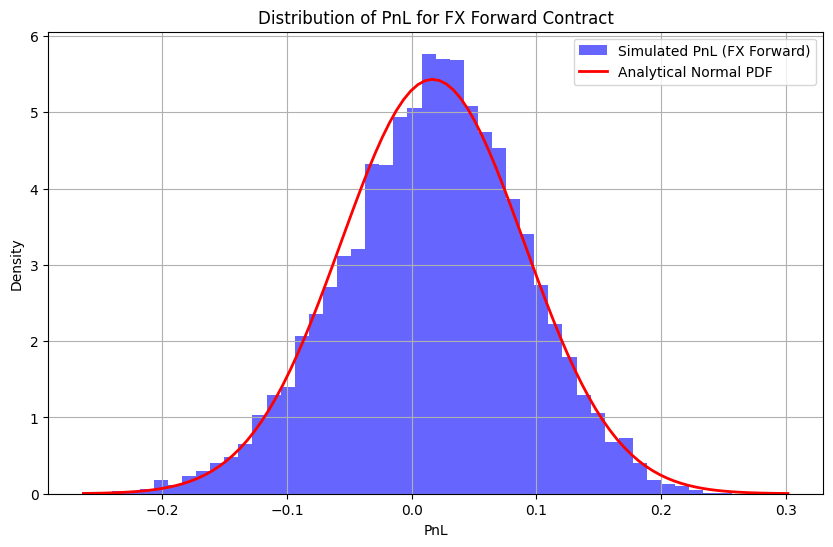

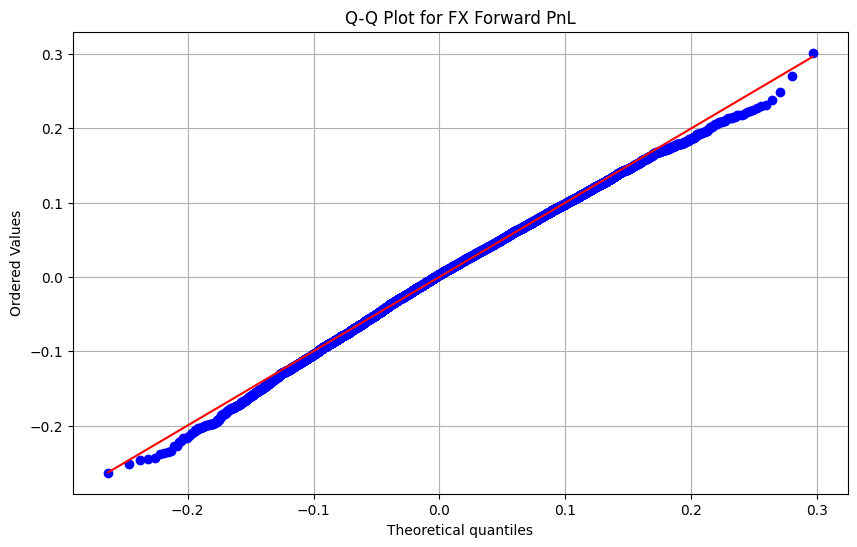

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest, probplot

# Vælg en specifik PnL-komponent til visualisering (f.eks. PnL for FX forward)
PnL_FX = PnL_1_EUR[:, 0]  # Første kolonne for FX forward kontrakt

# Beregn analytiske parametre for normalfordelingen
mu_FX = E_PnL[0]  # Forventning for FX forward PnL
sigma_FX = np.sqrt(Sigma_PnL[0, 0])  # Standardafvigelse for FX forward PnL

# Goodness-of-fit: Kolmogorov-Smirnov test
ks_stat, ks_p_value = kstest(PnL_FX, 'norm', args=(mu_FX, sigma_FX))

# Resultat af KS-test
print(f"Kolmogorov-Smirnov Test for Normality:")
print(f"KS Statistic: {ks_stat:.4f}, P-Value: {ks_p_value:.4f}")
if ks_p_value > 0.05:
    print("Testen kan IKKE forkaste, at PnL følger en normalfordeling (p > 0.05).")
else:
    print("Testen forkaster hypotesen om normalfordeling (p < 0.05).")

# Generer analytisk normalfordeling
x_values = np.linspace(PnL_FX.min(), PnL_FX.max(), 100)
pdf_values = norm.pdf(x_values, loc=mu_FX, scale=sigma_FX)

# Plot simulering og analytisk normalfordeling
plt.figure(figsize=(10, 6))
plt.hist(PnL_FX, bins=50, density=True, alpha=0.6, color="blue", label="Simulated PnL (FX Forward)")
plt.plot(x_values, pdf_values, color="red", linewidth=2, label="Analytical Normal PDF")
plt.title("Distribution of PnL for FX Forward Contract")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

# Q-Q plot for at vurdere normalitet
plt.figure(figsize=(10, 6))
probplot(PnL_FX, dist="norm", sparams=(mu_FX, sigma_FX), plot=plt)
plt.title("Q-Q Plot for FX Forward PnL")
plt.grid()
plt.show()


Kolmogorov-Smirnov Test for Normality (Portfolio PnL):
KS Statistic: 0.0235, P-Value: 0.0000
Testen forkaster hypotesen om normalfordeling (p < 0.05).


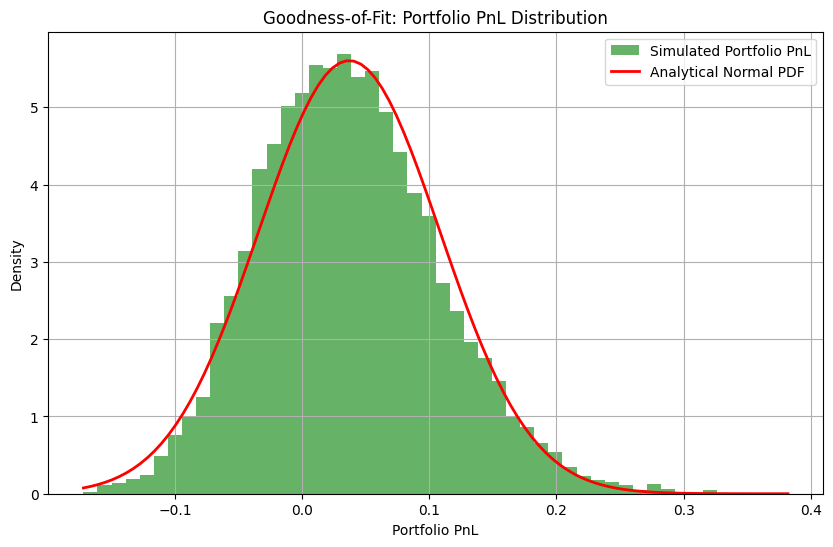

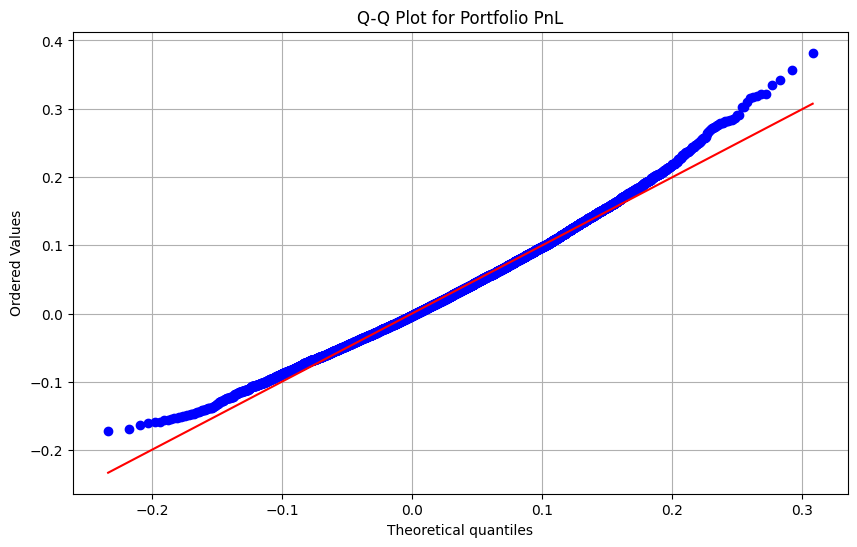

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest, probplot

# Antag en holdningsvektor for porteføljen
h = np.array([0.2, 0.2, 0.3, 0.3])  # Eksempel: 0.2 i aktier, 0.3 i bonds (4-dimensionel vektor)

# Beregn den samlede portefølje-PnL
PnL_portfolio = PnL_1_EUR[:, 1:] @ h  # Udelad FX forward og tag de sidste 4 komponenter

# Beregn analytiske parametre for portefølje-PnL
mu_portfolio = np.mean(PnL_portfolio)  # Forventet værdi
sigma_portfolio = np.std(PnL_portfolio)  # Standardafvigelse

# Goodness-of-fit: Kolmogorov-Smirnov test
ks_stat, ks_p_value = kstest(PnL_portfolio, 'norm', args=(mu_portfolio, sigma_portfolio))

# Udskriv KS-test resultatet
print("Kolmogorov-Smirnov Test for Normality (Portfolio PnL):")
print(f"KS Statistic: {ks_stat:.4f}, P-Value: {ks_p_value:.4f}")
if ks_p_value > 0.05:
    print("Testen kan IKKE forkaste, at portefølje-PnL følger en normalfordeling (p > 0.05).")
else:
    print("Testen forkaster hypotesen om normalfordeling (p < 0.05).")

# Generer analytisk normalfordeling for portefølje-PnL
x_values = np.linspace(PnL_portfolio.min(), PnL_portfolio.max(), 100)
pdf_values = norm.pdf(x_values, loc=mu_portfolio, scale=sigma_portfolio)

# Plot histogram og analytisk normalfordeling
plt.figure(figsize=(10, 6))
plt.hist(PnL_portfolio, bins=50, density=True, alpha=0.6, color="green", label="Simulated Portfolio PnL")
plt.plot(x_values, pdf_values, color="red", linewidth=2, label="Analytical Normal PDF")
plt.title("Goodness-of-Fit: Portfolio PnL Distribution")
plt.xlabel("Portfolio PnL")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

# Q-Q plot for portefølje-PnL
plt.figure(figsize=(10, 6))
probplot(PnL_portfolio, dist="norm", sparams=(mu_portfolio, sigma_portfolio), plot=plt)
plt.title("Q-Q Plot for Portfolio PnL")
plt.grid()
plt.show()


# Question 7

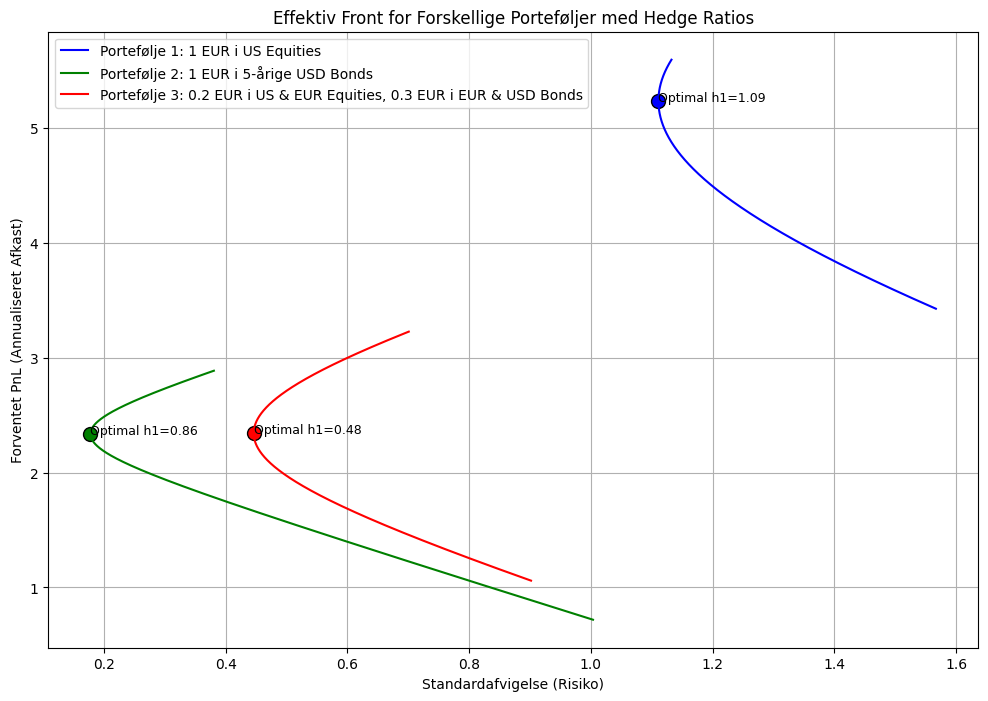

Portefølje 1: 1 EUR i US Equities:
Optimal Hedge Ratio (h1): 1.0860
Optimal Standard Deviation: 1.1109
Optimal Expected PnL: 5.2369

Portefølje 2: 1 EUR i 5-årige USD Bonds:
Optimal Hedge Ratio (h1): 0.8647
Optimal Standard Deviation: 0.1778
Optimal Expected PnL: 2.3365

Portefølje 3: 0.2 EUR i US & EUR Equities, 0.3 EUR i EUR & USD Bonds:
Optimal Hedge Ratio (h1): 0.4795
Optimal Standard Deviation: 0.4460
Optimal Expected PnL: 2.3427



In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- Input variabler ---
Sigma_PnL_annual = Sigma_PnL * 52  # Annualiseret kovariansmatrix
E_PnL_annual = E_PnL * 52  # Annualiseret forventet PnL

# --- Porteføljevægte ---
portfolios = [
    {'name': 'Portefølje 1: 1 EUR i US Equities', 'allocation': np.array([1, 0, 0, 0])},
    {'name': 'Portefølje 2: 1 EUR i 5-årige USD Bonds', 'allocation': np.array([0, 0, 1, 0])},
    {'name': 'Portefølje 3: 0.2 EUR i US & EUR Equities, 0.3 EUR i EUR & USD Bonds', 
     'allocation': np.array([0.2, 0.2, 0.3, 0.3])}
]

hedge_ratios = np.linspace(-1, 1.5, 1000)  # Hedge ratios fra -1 til 1.5

# --- Resultater ---
results = []
Sigma_PnL_new = []
E_PnL_new = []

# --- Beregninger ---
for portfolio in portfolios:
    h2 = portfolio['allocation']
    Sigma_PnL_12 = Sigma_PnL_annual[0, 1:5]
    Sigma_PnL_11 = Sigma_PnL_annual[0, 0]
    
    std_list = []
    pnl_list = []

    # Loop over hedge ratios
    for h1 in hedge_ratios:
        weights = np.concatenate(([h1], h2))
        
        # Forventet PnL og varians
        expected_pnl = np.dot(weights, E_PnL_annual)
        variance = np.dot(weights, np.dot(Sigma_PnL_annual, weights))
        std_dev = np.sqrt(variance)
        
        pnl_list.append(expected_pnl)
        std_list.append(std_dev)

    # Find optimal hedge ratio
    optimal_h1 = -np.dot(Sigma_PnL_12, h2) / Sigma_PnL_11
    weights_optimal = np.concatenate(([optimal_h1], h2))
    
    # Beregn ny kovariansmatrix og forventet PnL
    cov_new = np.dot(weights_optimal.T, np.dot(Sigma_PnL_annual, weights_optimal))
    e_pnl_new = np.dot(weights_optimal, E_PnL_annual)
    
    # Gem resultater
    Sigma_PnL_new.append(cov_new)
    E_PnL_new.append(e_pnl_new)
    results.append({
        'name': portfolio['name'],
        'std_dev': std_list,
        'pnl': pnl_list,
        'optimal_h1': optimal_h1,
        'optimal_std': np.sqrt(cov_new),
        'optimal_pnl': e_pnl_new
    })

# --- Plot resultater ---
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']

for idx, portfolio in enumerate(results):
    plt.plot(portfolio['std_dev'], portfolio['pnl'], label=portfolio['name'], color=colors[idx])
    plt.scatter(portfolio['optimal_std'], portfolio['optimal_pnl'], color=colors[idx], s=100, edgecolors='k')
    plt.text(portfolio['optimal_std'], portfolio['optimal_pnl'], 
             f"Optimal h1={portfolio['optimal_h1']:.2f}", fontsize=9)

plt.xlabel('Standardafvigelse (Risiko)')
plt.ylabel('Forventet PnL (Annualiseret Afkast)')
plt.title('Effektiv Front for Forskellige Porteføljer med Hedge Ratios')
plt.legend()
plt.grid(True)
plt.show()

# --- Udskriv resultater ---
for portfolio in results:
    print(f"{portfolio['name']}:")
    print(f"Optimal Hedge Ratio (h1): {portfolio['optimal_h1']:.4f}")
    print(f"Optimal Standard Deviation: {portfolio['optimal_std']:.4f}")
    print(f"Optimal Expected PnL: {portfolio['optimal_pnl']:.4f}\n")


KeyError: 'optimal_std'

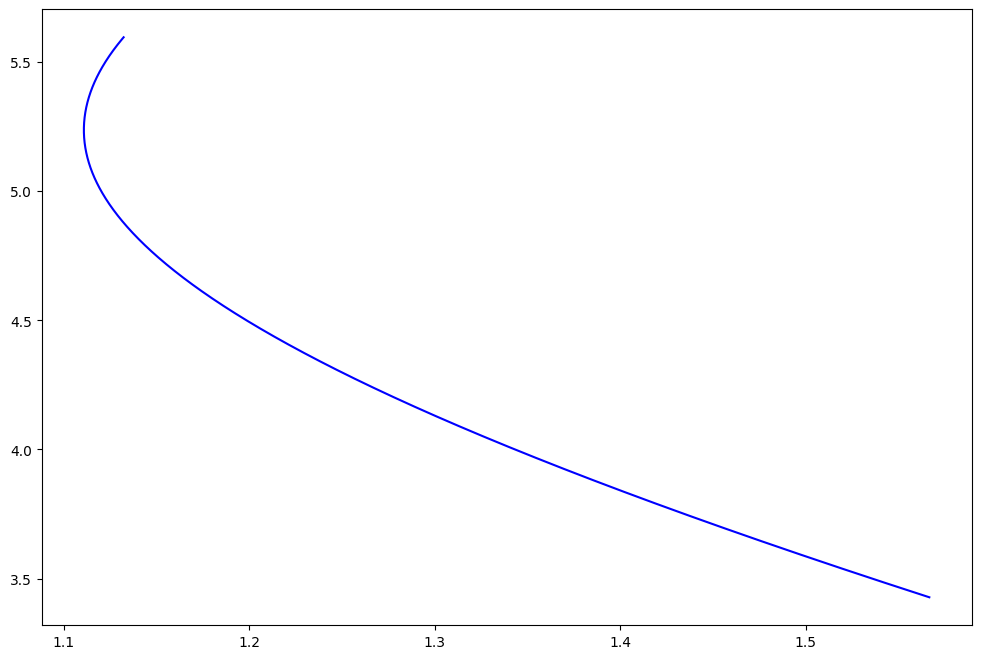

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Input variabler ---
Sigma_PnL_annual = Sigma_PnL * 52  # Annualiseret kovariansmatrix
E_PnL_annual = E_PnL * 52  # Annualiseret forventet PnL

# --- Porteføljevægte ---
portfolios = [
    {'name': 'Portefølje 1: 1 EUR i US Equities', 'allocation': np.array([1, 0, 0, 0])},
    {'name': 'Portefølje 2: 1 EUR i 5-årige USD Bonds', 'allocation': np.array([0, 0, 1, 0])},
    {'name': 'Portefølje 3: 0.2 EUR i US & EUR Equities, 0.3 EUR i EUR & USD Bonds', 
     'allocation': np.array([0.2, 0.2, 0.3, 0.3])}
]

hedge_ratios = np.linspace(-1, 1.5, 1000)  # Hedge ratios fra -1 til 1.5

# --- Resultater ---
results = []

# --- Beregninger ---
for portfolio in portfolios:
    h2 = portfolio['allocation']
    Sigma_PnL_12 = Sigma_PnL_annual[0, 1:5]  # Kovarians mellem hedge asset og andre aktiver
    Sigma_PnL_11 = Sigma_PnL_annual[0, 0]   # Varians af hedge asset

    std_list = []
    pnl_list = []
    Sigma_PnL_new = []
    E_PnL_new = []

    # Loop over hedge ratios
    for h1 in hedge_ratios:
        weights = np.concatenate(([h1], h2))

        # Ny forventet PnL
        expected_pnl = np.dot(weights, E_PnL_annual)
        E_PnL_new.append(expected_pnl)

        # Ny kovariansmatrix (varians for vægtede aktiver)
        variance = np.dot(weights, np.dot(Sigma_PnL_annual, weights))
        std_dev = np.sqrt(variance)
        Sigma_PnL_new.append(variance)

        # Gem resultater
        pnl_list.append(expected_pnl)
        std_list.append(std_dev)

    # Find optimal hedge ratio
    optimal_h1 = -np.dot(Sigma_PnL_12, h2) / Sigma_PnL_11
    weights_optimal = np.concatenate(([optimal_h1], h2))

    # Beregn optimal varians og forventet PnL
    cov_opt = np.dot(weights_optimal.T, np.dot(Sigma_PnL_annual, weights_optimal))
    e_pnl_opt = np.dot(weights_optimal, E_PnL_annual)

    # Gem resultater
    results.append({
        'name': portfolio['name'],
        'std_dev': std_list,
        'pnl': pnl_list,
        'Sigma_PnL_new': Sigma_PnL_new,  # Ny kovariansmatrix
        'E_PnL_new': E_PnL_new,         # Ny forventet PnL
        'optimal_h1': optimal_h1,
        'optimal_std': np.sqrt(cov_opt),
        'optimal_pnl': e_pnl_opt
    })

# --- Plot resultater ---
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']

for idx, portfolio in enumerate(results):
    plt.plot(portfolio['std_dev'], portfolio['pnl'], label=portfolio['name'], color=colors[idx])
    plt.scatter(portfolio['optimal_std'], portfolio['optimal_pnl'], color=colors[idx], s=100, edgecolors='k')
    plt.text(portfolio['optimal_std'], portfolio['optimal_pnl'], 
             f"Optimal h1={portfolio['optimal_h1']:.2f}", fontsize=9)

plt.xlabel('Standardafvigelse (Risiko)')
plt.ylabel('Forventet PnL (Annualiseret Afkast)')
plt.title('Effektiv Front for Forskellige Porteføljer med Hedge Ratios')
plt.legend()
plt.grid(True)
plt.show()

# --- Udskriv resultater ---
for portfolio in results:
    print(f"{portfolio['name']}:")
    print(f"Optimal Hedge Ratio (h1): {portfolio['optimal_h1']:.4f}")
    print(f"Optimal Standard Deviation: {portfolio['optimal_std']:.4f}")
    print(f"Optimal Expected PnL: {portfolio['optimal_pnl']:.4f}\n")


In [29]:
print(Sigma_PnL_new)
print(E_PnL_new)

[np.float64(0.8129406207329107), np.float64(0.8108652366377054), np.float64(0.8087933659195291), np.float64(0.8067250085783823), np.float64(0.8046601646142644), np.float64(0.8025988340271758), np.float64(0.8005410168171162), np.float64(0.7984867129840859), np.float64(0.7964359225280847), np.float64(0.7943886454491127), np.float64(0.7923448817471699), np.float64(0.7903046314222563), np.float64(0.7882678944743716), np.float64(0.7862346709035164), np.float64(0.78420496070969), np.float64(0.7821787638928932), np.float64(0.7801560804531251), np.float64(0.7781369103903865), np.float64(0.776121253704677), np.float64(0.7741091103959965), np.float64(0.7721004804643453), np.float64(0.7700953639097232), np.float64(0.7680937607321304), np.float64(0.7660956709315666), np.float64(0.7641010945080321), np.float64(0.7621100314615267), np.float64(0.7601224817920504), np.float64(0.7581384454996033), np.float64(0.7561579225841855), np.float64(0.7541809130457967), np.float64(0.7522074168844372), np.float64

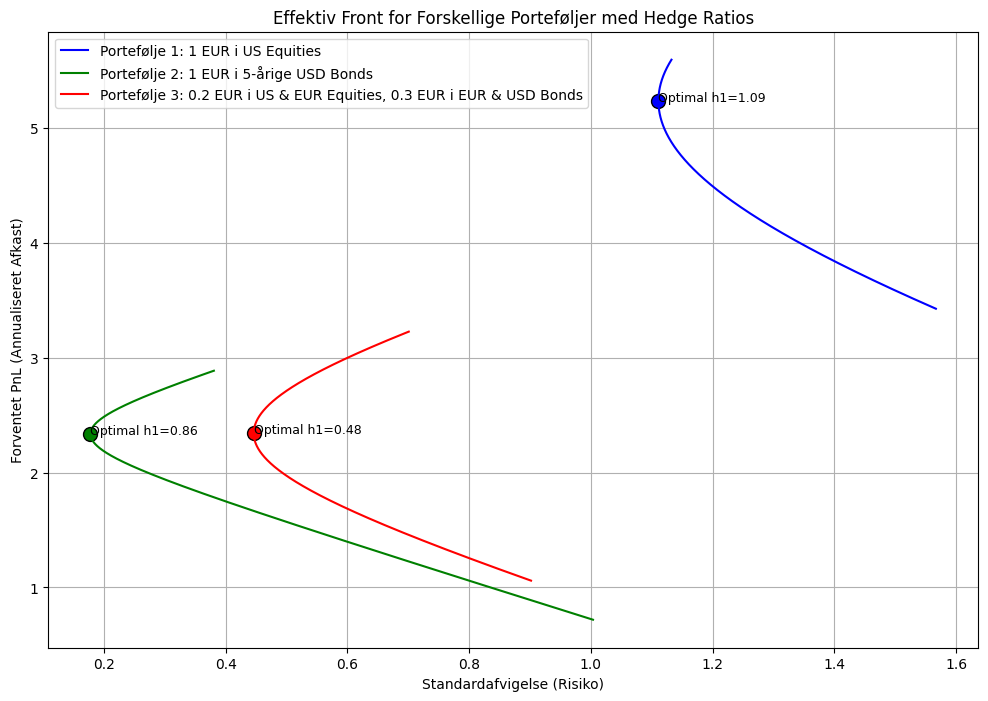

Portefølje 1: 1 EUR i US Equities:
Optimal Hedge Ratio (h1): 1.0860
Optimal Standard Deviation: 1.1109
Optimal Expected PnL: 5.2369

Portefølje 2: 1 EUR i 5-årige USD Bonds:
Optimal Hedge Ratio (h1): 0.8647
Optimal Standard Deviation: 0.1778
Optimal Expected PnL: 2.3365

Portefølje 3: 0.2 EUR i US & EUR Equities, 0.3 EUR i EUR & USD Bonds:
Optimal Hedge Ratio (h1): 0.4795
Optimal Standard Deviation: 0.4460
Optimal Expected PnL: 2.3427

E_PnL_new Dimensioner: (1000,)
Sigma_PnL_new Dimensioner: (1000,)


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- Input variabler ---
Sigma_PnL_annual = Sigma_PnL * 52  # Annualiseret kovariansmatrix (5x5 matrix)
E_PnL_annual = E_PnL * 52  # Annualiseret forventet PnL (1x5 vektor)

# --- Porteføljevægte ---
portfolios = [
    {'name': 'Portefølje 1: 1 EUR i US Equities', 'allocation': np.array([1, 0, 0, 0])},
    {'name': 'Portefølje 2: 1 EUR i 5-årige USD Bonds', 'allocation': np.array([0, 0, 1, 0])},
    {'name': 'Portefølje 3: 0.2 EUR i US & EUR Equities, 0.3 EUR i EUR & USD Bonds', 
     'allocation': np.array([0.2, 0.2, 0.3, 0.3])}
]

hedge_ratios = np.linspace(-1, 1.5, 1000)  # Hedge ratios fra -1 til 1.5

# --- Resultater ---
results = []

# --- Beregninger ---
for portfolio in portfolios:
    h2 = portfolio['allocation']  # Vægte til aktiverne udover FX forward
    Sigma_PnL_12 = Sigma_PnL_annual[0, 1:]  # Kovarians mellem hedge asset og de øvrige aktiver
    Sigma_PnL_11 = Sigma_PnL_annual[0, 0]   # Varians af hedge asset

    std_list = []
    pnl_list = []
    Sigma_PnL_new = []
    E_PnL_new = []

    # Loop over hedge ratios
    for h1 in hedge_ratios:
        # Samlede vægte (h1 + allokering h2)
        weights = np.concatenate(([h1], h2))

        # Ny forventet PnL som en 1x5 vektor
        E_PnL_updated = np.dot(weights, E_PnL_annual)
        E_PnL_new.append(E_PnL_updated)

        # Ny kovariansmatrix som 5x5
        Sigma_PnL_updated = weights.T @ Sigma_PnL_annual @ weights
        Sigma_PnL_new.append(Sigma_PnL_updated)

        # Standardafvigelse (risiko)
        std_dev = np.sqrt(Sigma_PnL_updated)
        pnl_list.append(E_PnL_updated)
        std_list.append(std_dev)

    # Find optimal hedge ratio analytisk
    optimal_h1 = -np.dot(Sigma_PnL_12, h2) / Sigma_PnL_11
    weights_optimal = np.concatenate(([optimal_h1], h2))

    # Optimal varians og forventet PnL
    cov_opt = weights_optimal.T @ Sigma_PnL_annual @ weights_optimal
    e_pnl_opt = np.dot(weights_optimal, E_PnL_annual)

    # Gem resultater
    results.append({
        'name': portfolio['name'],
        'std_dev': std_list,
        'pnl': pnl_list,
        'Sigma_PnL_new': Sigma_PnL_new,  # Ny kovariansmatrix (5x5)
        'E_PnL_new': E_PnL_new,         # Ny forventet PnL (1x5)
        'optimal_h1': optimal_h1,
        'optimal_std': np.sqrt(cov_opt),
        'optimal_pnl': e_pnl_opt
    })

# --- Plot resultater ---
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']

for idx, portfolio in enumerate(results):
    plt.plot(portfolio['std_dev'], portfolio['pnl'], label=portfolio['name'], color=colors[idx])
    plt.scatter(portfolio['optimal_std'], portfolio['optimal_pnl'], color=colors[idx], s=100, edgecolors='k')
    plt.text(portfolio['optimal_std'], portfolio['optimal_pnl'], 
             f"Optimal h1={portfolio['optimal_h1']:.2f}", fontsize=9)

plt.xlabel('Standardafvigelse (Risiko)')
plt.ylabel('Forventet PnL (Annualiseret Afkast)')
plt.title('Effektiv Front for Forskellige Porteføljer med Hedge Ratios')
plt.legend()
plt.grid(True)
plt.show()

# --- Udskriv resultater ---
for portfolio in results:
    print(f"{portfolio['name']}:")
    print(f"Optimal Hedge Ratio (h1): {portfolio['optimal_h1']:.4f}")
    print(f"Optimal Standard Deviation: {portfolio['optimal_std']:.4f}")
    print(f"Optimal Expected PnL: {portfolio['optimal_pnl']:.4f}\n")

# Tjek dimensioner for E_PnL_new og Sigma_PnL_new
print(f"E_PnL_new Dimensioner: {np.shape(results[0]['E_PnL_new'])}")
print(f"Sigma_PnL_new Dimensioner: {np.shape(results[0]['Sigma_PnL_new'])}")


In [33]:
print(E_PnL_new)
print(Sigma_PnL_new)

[np.float64(1.059449805310754), np.float64(1.0616204240444247), np.float64(1.0637910427780954), np.float64(1.0659616615117662), np.float64(1.068132280245437), np.float64(1.0703028989791077), np.float64(1.0724735177127784), np.float64(1.0746441364464492), np.float64(1.07681475518012), np.float64(1.078985373913791), np.float64(1.0811559926474616), np.float64(1.0833266113811324), np.float64(1.0854972301148031), np.float64(1.087667848848474), np.float64(1.0898384675821446), np.float64(1.0920090863158154), np.float64(1.0941797050494861), np.float64(1.0963503237831569), np.float64(1.0985209425168276), np.float64(1.1006915612504986), np.float64(1.1028621799841694), np.float64(1.10503279871784), np.float64(1.1072034174515109), np.float64(1.1093740361851816), np.float64(1.1115446549188523), np.float64(1.113715273652523), np.float64(1.1158858923861938), np.float64(1.1180565111198646), np.float64(1.1202271298535353), np.float64(1.122397748587206), np.float64(1.124568367320877), np.float64(1.12673

# Question 8

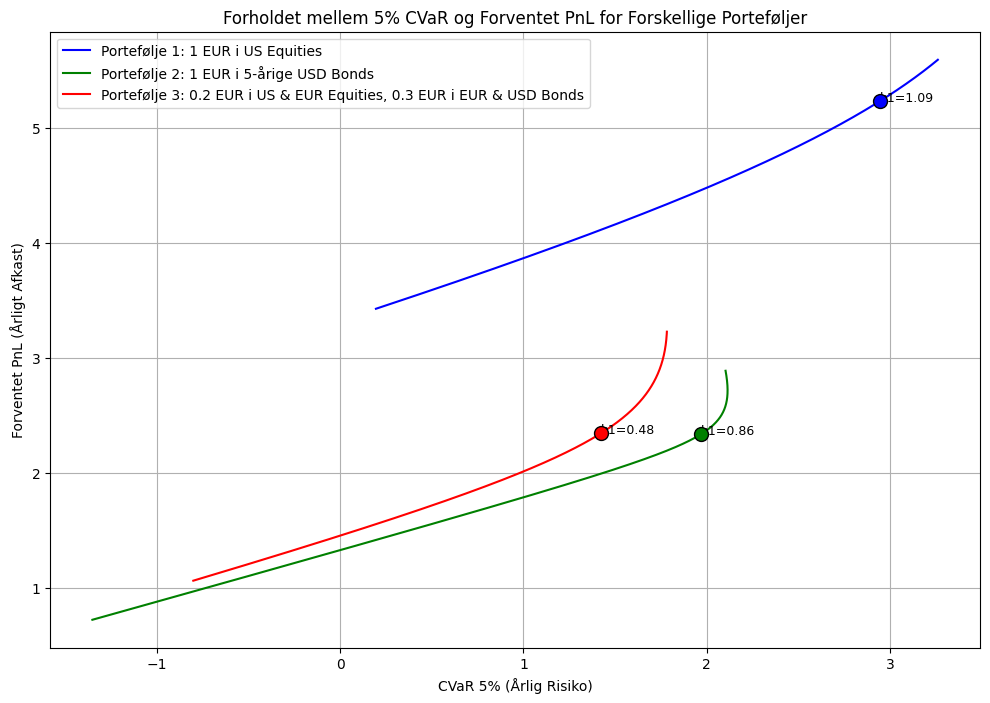

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parametre ---
alpha = 0.05  # 5% CVaR
phi_z = norm.pdf(norm.ppf(alpha))  # PDF for normalfordeling ved alpha
num_simulations = 10000  # Finere grid for hedge ratio
h1_values = np.linspace(-1, 1.5, num_simulations)  # Hedge ratio fra -1.5 til 1.5

# --- Årlig skalering ---
Sigma_PnL_annual = Sigma_PnL*52   # Skaler kovariansmatrix til årligt format
E_PnL_annual = E_PnL *52 # Skaler forventet PnL til årligt format

# --- Definér porteføljer ---
portfolios = [
    {'name': 'Portefølje 1: 1 EUR i US Equities', 'allocation': np.array([1, 0, 0, 0])},
    {'name': 'Portefølje 2: 1 EUR i 5-årige USD Bonds', 'allocation': np.array([0, 0, 1, 0])},
    {'name': 'Portefølje 3: 0.2 EUR i US & EUR Equities, 0.3 EUR i EUR & USD Bonds', 
     'allocation': np.array([0.2, 0.2, 0.3, 0.3])}
]

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parametre ---
alpha = 0.05  # 5% CVaR
phi_z = norm.pdf(norm.ppf(alpha))  # PDF for normalfordeling ved alpha
num_simulations = 1000  # Finere grid for hedge ratio
h1_values = np.linspace(-1, 1.5, num_simulations)  # Hedge ratio fra -1 til 1.5


# --- Definér porteføljer ---
portfolios = [
    {'name': 'Portefølje 1: 1 EUR i US Equities', 'allocation': np.array([1, 0, 0, 0])},
    {'name': 'Portefølje 2: 1 EUR i 5-årige USD Bonds', 'allocation': np.array([0, 0, 1, 0])},
    {'name': 'Portefølje 3: 0.2 EUR i US & EUR Equities, 0.3 EUR i EUR & USD Bonds',
     'allocation': np.array([0.2, 0.2, 0.3, 0.3])}
]

# --- Beregninger for hver portefølje ---
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red']

for idx, portfolio in enumerate(portfolios):
    h2 = portfolio['allocation']
    Sigma_12 = Sigma_PnL_annual[0, 1:]  # Kovarians mellem hedge asset og portefølje
    Sigma_11 = Sigma_PnL_annual[0, 0]   # Varians af hedge asset

    # Optimal hedge ratio h1 analytisk
    h1_opt = -np.dot(Sigma_12, h2) / Sigma_11

    # Samlet vægt for optimal hedge ratio
    weights_opt = np.concatenate(([h1_opt], h2))
    E_PnL_opt = np.dot(weights_opt, E_PnL_annual)
    std_PnL_opt = np.sqrt(np.dot(weights_opt, np.dot(Sigma_PnL_annual, weights_opt)))
    CVaR_opt = E_PnL_opt - std_PnL_opt * (phi_z / alpha)

    # Variér hedge ratio h1
    CVaR_5_values = []
    E_PnL_values = []

    for h1 in h1_values:
        weights = np.concatenate(([h1], h2))
        mu = np.dot(weights, E_PnL_annual)
        sigma = np.sqrt(np.dot(weights, np.dot(Sigma_PnL_annual, weights)))
        CVaR_5 = mu - sigma * (phi_z / alpha)

        CVaR_5_values.append(CVaR_5)
        E_PnL_values.append(mu)

    # Plot CVaR vs. forventet PnL for hedge ratios
    plt.plot(CVaR_5_values, E_PnL_values, label=portfolio['name'], color=colors[idx])

    # Plot optimal hedge ratio
    plt.scatter(CVaR_opt, E_PnL_opt, color=colors[idx], edgecolors='k', s=100, zorder=5)
    plt.text(CVaR_opt, E_PnL_opt, f"h1={h1_opt:.2f}", fontsize=9)

# --- Plot indstillinger ---
plt.xlabel('CVaR 5% (Årlig Risiko)')
plt.ylabel('Forventet PnL (Årligt Afkast)')
plt.title('Forholdet mellem 5% CVaR og Forventet PnL for Forskellige Porteføljer')
plt.legend()
plt.grid(True)
plt.show()



# Question 9

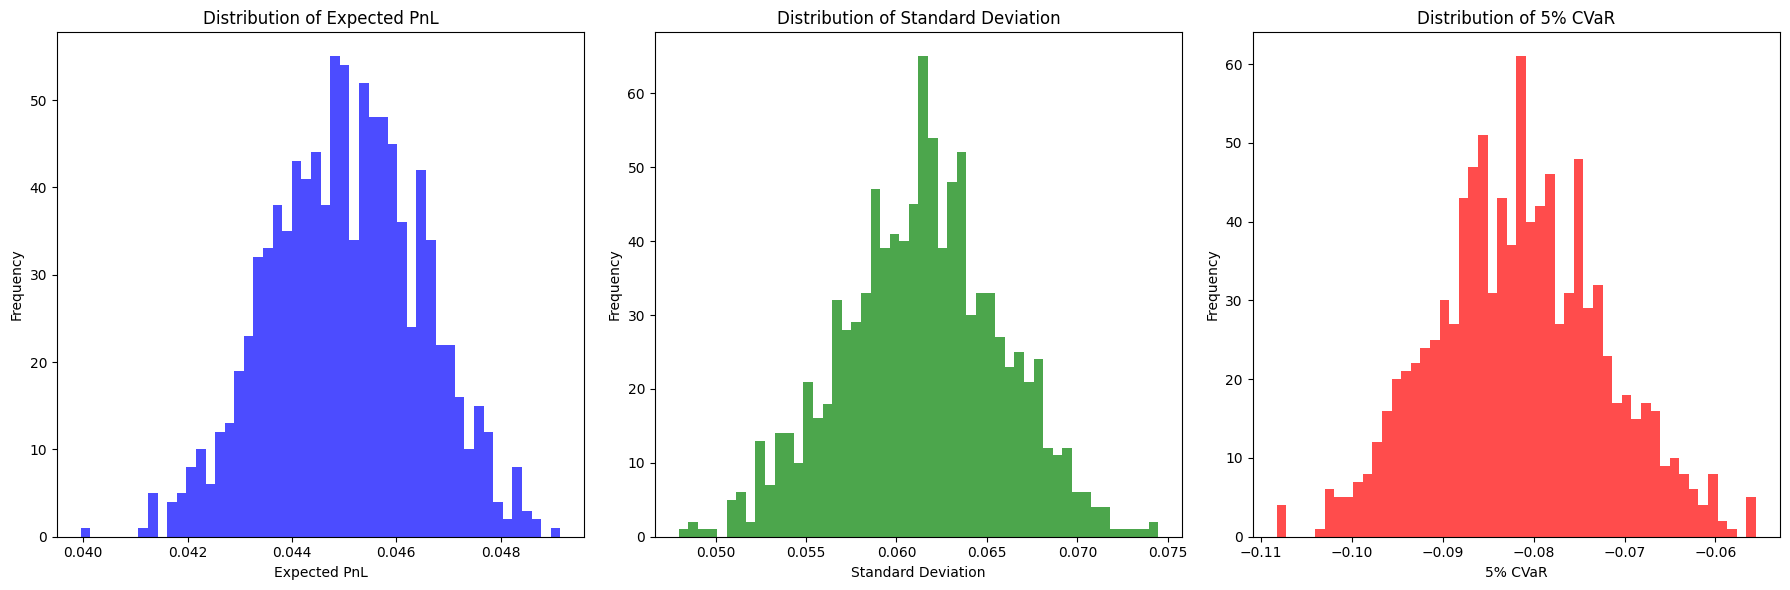

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

# --- Parametre ---
num_simulations = 1000  # Antal simuleringer
alpha = 0.05  # 5% CVaR
phi_z = norm.pdf(norm.ppf(alpha))  # PDF ved 5% kvantil

# --- Sand kovarians og forventning ---
true_Sigma_PnL = Sigma_PnL    # Årlig kovariansmatrix
true_E_PnL = E_PnL   # Årlig forventet PnL

# --- Portefølje: 0.2 i US/EUR Equities, 0.3 i USD/EUR Bonds ---
portfolio_weights = np.array([0.2, 0.2, 0.3, 0.3])

# --- Resultatlister ---
expected_PnL_list = []
std_dev_list = []
cvar_5_list = []

# --- Simuleringer ---
for _ in range(num_simulations):
    # Simuler stikprøve af kovariansmatrix
    simulated_data = np.random.multivariate_normal(mean=np.zeros(true_Sigma_PnL.shape[0]),
                                                   cov=true_Sigma_PnL, size=100)
    sample_cov = np.cov(simulated_data, rowvar=False)

    # Optimal hedge ratio h1 (kun hvis relevant)
    Sigma_11 = sample_cov[0, 0]
    Sigma_12 = sample_cov[0, 1:]
    h1_opt = -np.dot(Sigma_12, portfolio_weights) / Sigma_11
    weights = np.concatenate(([h1_opt], portfolio_weights))

    # Beregn resultater
    E_PnL_sim = np.dot(weights, true_E_PnL)
    var_PnL_sim = np.dot(weights, np.dot(sample_cov, weights))
    std_dev_sim = np.sqrt(var_PnL_sim)
    cvar_5_sim = E_PnL_sim - std_dev_sim * (phi_z / alpha)

    # Gem resultater
    expected_PnL_list.append(E_PnL_sim)
    std_dev_list.append(std_dev_sim)
    cvar_5_list.append(cvar_5_sim)

# --- Plot Resultaterne ---
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Expected PnL
ax[0].hist(expected_PnL_list, bins=50, color="blue", alpha=0.7)
ax[0].set_title("Distribution of Expected PnL")
ax[0].set_xlabel("Expected PnL")
ax[0].set_ylabel("Frequency")

# Plot 2: Standard Deviation
ax[1].hist(std_dev_list, bins=50, color="green", alpha=0.7)
ax[1].set_title("Distribution of Standard Deviation")
ax[1].set_xlabel("Standard Deviation")
ax[1].set_ylabel("Frequency")

# Plot 3: 5% CVaR
ax[2].hist(cvar_5_list, bins=50, color="red", alpha=0.7)
ax[2].set_title("Distribution of 5% CVaR")
ax[2].set_xlabel("5% CVaR")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# Question 10


In [22]:
# Beregn de asset-specific optimale hedge ratios (h1)
# Hedge ratio for US Equities
Sigma_US_equities = Sigma_PnL[0, 0]  # Varians af FX forward
Cov_US_equities = E_PnL[0, 1]    # Kovarians mellem FX forward og US equities
h1_US_equities = - Cov_US_equities / Sigma_US_equities

# Hedge ratio for US Bonds
Cov_US_bonds = Sigma_PnL[0, 3]       # Kovarians mellem FX forward og US bonds
h1_US_bonds = - Cov_US_bonds / Sigma_US_equities

print("Optimal hedge ratio for US equities:", h1_US_equities)
print("Optimal hedge ratio for US bonds:", h1_US_bonds)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Optimal hedge ratio for US equities: 1.0860055858157591
Optimal hedge ratio for US bonds: 0.8646506101131224


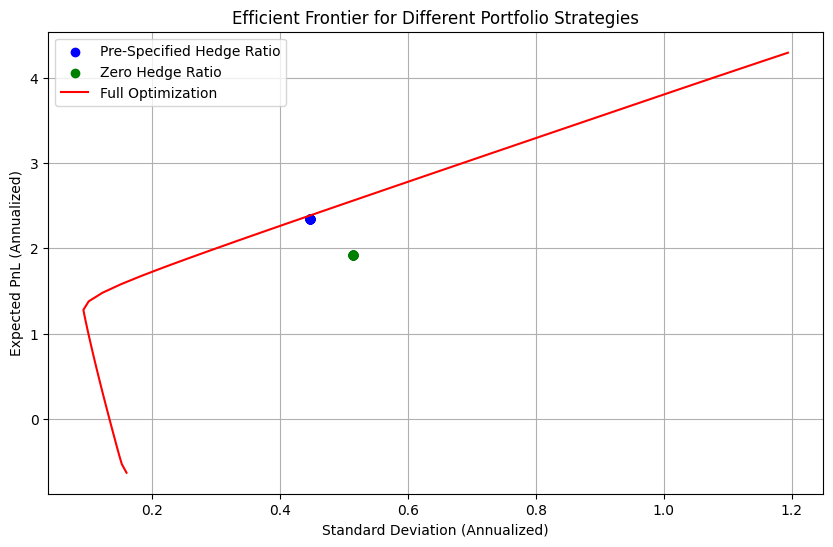

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Parametre
num_assets = 4  # Antal aktiver (uden forward kontrakten)
alpha = 0.05
num_targets = 50  # Antal PnL mål på Efficient Frontier

# Porteføljeallokering
h2_fixed = np.array([0.2, 0.2, 0.3, 0.3])

# Beregn de asset-specific optimale hedge ratios (h1)
Sigma_US_equities = Sigma_PnL_annual[0, 0]  # Varians af FX forward
Cov_US_equities = Sigma_PnL_annual[0, 1]    # Kovarians mellem FX forward og US equities
h1_US_equities = - Cov_US_equities / Sigma_US_equities

Cov_US_bonds = Sigma_PnL_annual[0, 3]       # Kovarians mellem FX forward og US bonds
h1_US_bonds = - Cov_US_bonds / Sigma_US_equities

print("Optimal hedge ratio for US equities:", h1_US_equities)
print("Optimal hedge ratio for US bonds:", h1_US_bonds)

# Funktion: Beregn h1 som en vægtet gennemsnit af pre-specified hedge ratios
def compute_h1_pre_specified(h2):
    hedge_ratios = np.array([h1_US_equities, 0, h1_US_bonds, 0])
    h1 = np.dot(h2, hedge_ratios)
    return h1

# Mean-Variance Optimization med pre-specified hedge ratios
def pre_specified_strategy(h2_allocation, Sigma, mu):
    h1 = compute_h1_pre_specified(h2_allocation)
    weights = np.concatenate(([h1], h2_allocation))
    pnl = np.dot(weights, mu)
    std = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))
    return pnl, std

# Mean-Variance Optimization med h1 = 0
def zero_hedge_strategy(h2_allocation, Sigma, mu):
    h1 = 0
    weights = np.concatenate(([h1], h2_allocation))
    pnl = np.dot(weights, mu)
    std = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))
    return pnl, std

# Full Mean-Variance Optimization
def full_optimization(Sigma, mu, target_pnl):
    def objective(w):
        return np.sqrt(w.T @ Sigma @ w)  # Minimer varians
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.dot(w, mu) - target_pnl},  # PnL constraint
                   {'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Budget constraint
    
    bounds = [(None, None)] + [(0, None)] * (len(mu) - 1)  # Ikke-short constraint
    w0 = np.ones(len(mu)) / len(mu)
    
    result = minimize(objective, w0, constraints=constraints, bounds=bounds)
    return result.x

# Beregn efficient frontier for hver strategi
returns = np.linspace(min(E_PnL_annual), max(E_PnL_annual), num_targets)
strategies = {'Pre-Specified Hedge Ratio': [], 'Zero Hedge Ratio': [], 'Full Optimization': []}

for target in returns:
    # Pre-Specified Strategy
    pnl1, std1 = pre_specified_strategy(h2_fixed, Sigma_PnL_annual, E_PnL_annual)
    strategies['Pre-Specified Hedge Ratio'].append((std1, pnl1))
    
    # Zero Hedge Strategy
    pnl2, std2 = zero_hedge_strategy(h2_fixed, Sigma_PnL_annual, E_PnL_annual)
    strategies['Zero Hedge Ratio'].append((std2, pnl2))
    
    # Full Optimization
    w_opt = full_optimization(Sigma_PnL_annual, E_PnL_annual, target)
    pnl3 = np.dot(w_opt, E_PnL_annual)
    std3 = np.sqrt(np.dot(w_opt, np.dot(Sigma_PnL_annual, w_opt)))
    strategies['Full Optimization'].append((std3, pnl3))

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']

for i, (name, values) in enumerate(strategies.items()):
    if values:  # Plot kun hvis der er værdier
        risks, pnls = zip(*values)
        if name == "Pre-Specified Hedge Ratio" or name == "Zero Hedge Ratio":
            # Plot som punkter
            plt.scatter(risks, pnls, label=name, color=colors[i])
        else:
            # Plot som kurve
            plt.plot(risks, pnls, label=name, color=colors[i])

plt.xlabel('Standard Deviation (Annualized)')
plt.ylabel('Expected PnL (Annualized)')
plt.title('Efficient Frontier for Different Portfolio Strategies')
plt.legend()
plt.grid()
plt.show()


# Question 11

ValueError: The 'color' keyword argument must have one color per dataset, but 1000 datasets and 1 colors were provided

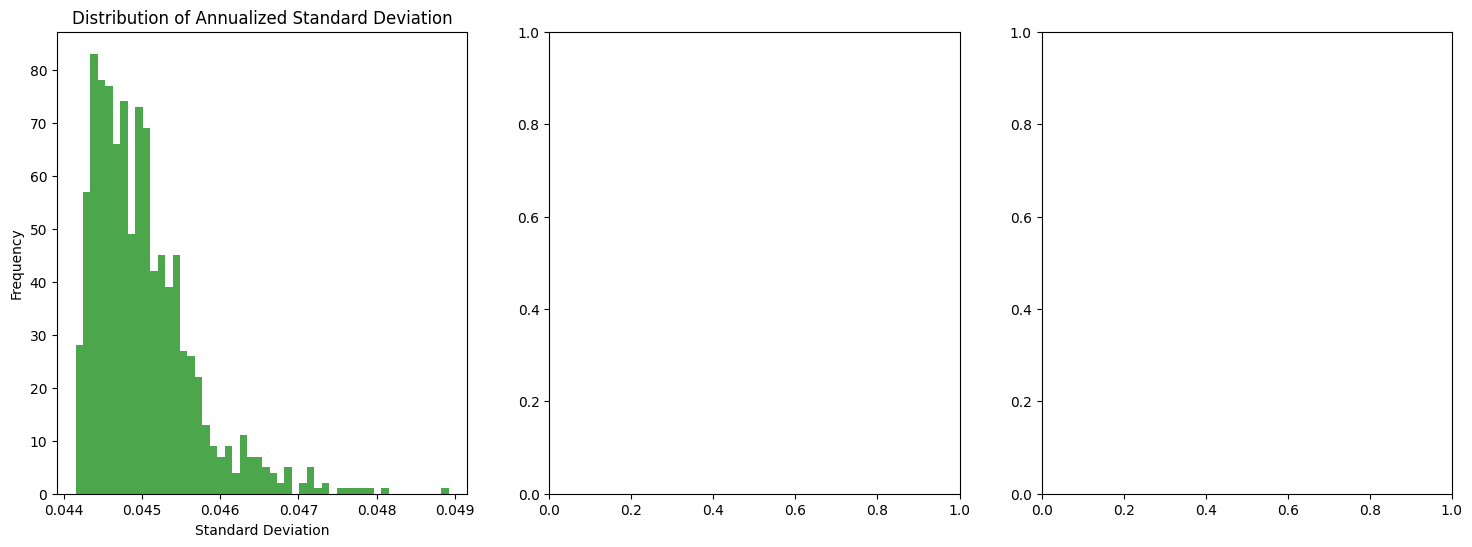

In [179]:
import numpy as np
import matplotlib.pyplot as plt

# Parametre
num_obs = 104  # To års ugentlige observationer (52 * 2)
num_simulations = 1000  # Antal simuleringer
alpha = 0.05  # CVaR niveau
z = np.abs(np.random.normal(0, 1))  # Kvantil til CVaR beregning

# Sand kovariansmatrix og fast forventet afkast
true_Sigma = Sigma_PnL   # Årlig kovariansmatrix
mu_fixed = new_covariance   # Årligt fast forventet afkast
num_assets = true_Sigma.shape[0]

# Funktioner
def portfolio_variance(weights, Sigma):
    """Beregn porteføljevarians givet vægte og kovariansmatrix."""
    return weights.T @ Sigma @ weights

def min_variance_weights(Sigma):
    """Beregn optimale vægte for minimum-varians portefølje."""
    inv_Sigma = np.linalg.inv(Sigma)
    ones = np.ones((Sigma.shape[0], 1))
    weights = inv_Sigma @ ones / (ones.T @ inv_Sigma @ ones)
    return weights.flatten()

# Simuleringsresultater
PnL_values = []
Std_values = []
CVaR_5_values = []

# Simuler estimation uncertainty fra sample covariance matrices
for _ in range(num_simulations):
    # Simuler data fra multivariat normalfordeling
    simulated_data = np.random.multivariate_normal(mean=np.zeros(num_assets),
                                                   cov=true_Sigma, size=num_obs)
    sample_Sigma = np.cov(simulated_data, rowvar=False)
    
    # Beregn optimale vægte for minimum-varians porteføljen
    weights = min_variance_weights(sample_Sigma)
    
    # Beregn resultater (baseret på den sande Σ og fast μ)
    mu_pnl = np.dot(weights, mu_fixed)
    var_pnl = portfolio_variance(weights, true_Sigma)
    std_pnl = np.sqrt(var_pnl)
    cvar_5 = mu_pnl - std_pnl * z / alpha  # 5% CVaR
    
    # Gem resultater
    PnL_values.append(mu_pnl)
    Std_values.append(std_pnl)
    CVaR_5_values.append(cvar_5)

# Plot resultater
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Histogram for standardafvigelse
axs[0].hist(Std_values, bins=50, color='green', alpha=0.7)
axs[0].set_title('Distribution of Annualized Standard Deviation')
axs[0].set_xlabel('Standard Deviation')
axs[0].set_ylabel('Frequency')

# Histogram for forventet PnL
axs[1].hist(PnL_values, bins=50, color='blue', alpha=0.7)
axs[1].set_title('Distribution of Annualized Expected PnL')
axs[1].set_xlabel('Expected PnL')
axs[1].set_ylabel('Frequency')

# Histogram for 5% CVaR
axs[2].hist(CVaR_5_values, bins=50, color='red', alpha=0.7)
axs[2].set_title('Distribution of Annualized 5% CVaR')
axs[2].set_xlabel('5% CVaR')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Udskriv resultater
print(f"Mean Annualized Std Dev: {np.mean(Std_values):.4f}")
print(f"Mean Annualized Expected PnL: {np.mean(PnL_values):.4f}")
print(f"Mean Annualized 5% CVaR: {np.mean(CVaR_5_values):.4f}")
